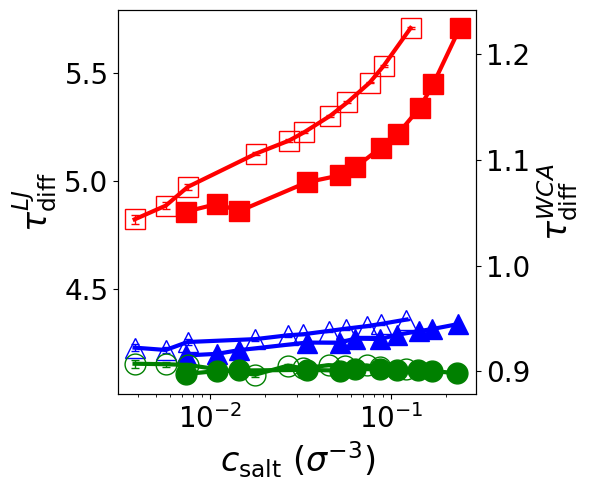

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "./"

concentrate_file = "concentrate_volume.csv"
concentrate_data = pd.read_csv(concentrate_file)
for col in concentrate_data.columns:
    globals()[col] = concentrate_data[col].dropna().to_numpy()


# ---------- Load Dpp, Dmm from new files ---------- #
def load_dpp_dmm(eps, model):
    fname = f"{file_path}Diffusion_fit_MD_{eps}_{model}.csv"
    df = pd.read_csv(fname)

    D_cat = df["Dpp"].values          # D++
    D_cat_err = df["Dpp_err"].values
    D_ani = df["Dmm"].values          # D--
    D_ani_err = df["Dmm_err"].values

    return D_cat, D_cat_err, D_ani, D_ani_err

# ---------- τ_diff function ---------- #
def tau_diff(D_cat, D_ani, err_cat, err_ani, sigma=1.5):
    D_cat, D_ani = np.array(D_cat), np.array(D_ani)
    err_cat, err_ani = np.array(err_cat), np.array(err_ani)

    D_salt = 0.5 * (D_cat + D_ani)
    tau = sigma**2 / (6.0 * D_salt)

    D_salt_err = np.sqrt((0.5 * err_cat)**2 + (0.5 * err_ani)**2)
    tau_err = (sigma**2 / 6.0) * (D_salt_err / (D_salt**2))

    return tau, tau_err


# ---------- Compute τ_diff for all LJ/WCA ---------- #
tau_mean, tau_err = {}, {}

for eps in ['0.2', '1', '5']:
    key = eps.replace('.', '')

    # LJ
    D_cat, D_cat_err, D_ani, D_ani_err = load_dpp_dmm(eps, "LJ")
    tau_mean[f"{key}_lj"], tau_err[f"{key}_lj"] = tau_diff(D_cat, D_ani, D_cat_err, D_ani_err)

    # WCA
    D_cat, D_cat_err, D_ani, D_ani_err = load_dpp_dmm(eps, "WCA")
    tau_mean[f"{key}_wca"], tau_err[f"{key}_wca"] = tau_diff(D_cat, D_ani, D_cat_err, D_ani_err)


# ---------- Plot settings ---------- #
color_map = {'0.2': 'red', '1': 'blue', '5': 'green'}
marker_map = {'0.2': 's', '1': '^', '5': 'o'}

fig, ax_l = plt.subplots(figsize=(6, 5))
ax_r = ax_l.twinx()

# ---------- LJ ---------- #
for eps in ['0.2', '1', '5']:
    if eps=="0.2":
        eps_temp = "02"
    else:
        eps_temp = eps
    x = f"mean_c_salt_{eps_temp}_lj"
    x = globals()[x] 
    key = eps.replace('.', '')
    y_vals = tau_mean[f"{key}_lj"]
    y_err = tau_err[f"{key}_lj"]

    ax_l.plot(x, y_vals, color=color_map[eps], linewidth=3)
    ax_l.errorbar(
        x, y_vals, yerr=y_err,
        fmt=marker_map[eps], color=color_map[eps],
        mfc=color_map[eps], mec=color_map[eps], markersize=15,
        elinewidth=1, capsize=3, label=f"{eps} LJ"
    )

# ---------- WCA ---------- #
for eps in ['0.2', '1', '5']:
    if eps=="0.2":
        eps_temp = "02"
    else:
        eps_temp = eps
    x = f"mean_c_salt_{eps_temp}_wca"
    x = globals()[x] 
    key = eps.replace('.', '')
    y_vals = tau_mean[f"{key}_wca"]
    y_err = tau_err[f"{key}_wca"]

    ax_r.plot(x, y_vals, color=color_map[eps], linewidth=3)
    ax_r.errorbar(
        x, y_vals, yerr=y_err,
        fmt=marker_map[eps], color=color_map[eps],
        mfc='none', mec=color_map[eps], markersize=15,
        elinewidth=1, capsize=3, label=f"{eps} WCA"
    )

# ---------- Axis styling ---------- #
ax_l.set_xlabel(r'$c_{\mathrm{salt}}$ $(\sigma^{-3})$', fontsize=24)
ax_l.set_ylabel(r'$\tau_{\mathrm{diff}}^{LJ}$', fontsize=24)
ax_r.set_ylabel(r'$\tau_{\mathrm{diff}}^{WCA}$', fontsize=24)

ax_l.set_xscale("log")
ax_l.tick_params(axis='both', labelsize=20)
ax_r.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.show()